#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18
NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [3]:
from sklearn.tree import DecisionTreeRegressor

def get_model():
    """
    Create and configure a DecisionTreeRegressor model.
    The model is fine-tuned to balance predictive power and generalization.
    """
    model = DecisionTreeRegressor(
        max_depth=6,  # Slightly deeper trees to capture more complex relationships
        min_samples_split=15,  # Require more samples per split to improve stability
        min_samples_leaf=5,  # Ensure each leaf contains enough samples to reduce overfitting
        max_features="sqrt",  # Limit features considered at each split to reduce variance
        random_state=42  # For reproducibility
    )
    return model


**Explanation:**Using a Decision Tree Regressor can significantly improve price prediction compared to a linear model like Linear Regression. Additionally, the use of max_features="sqrt" reduces the variance by considering only a subset of features at each split. This makes the model particularly useful in cases where relationships between variables are non-linear, and the data exhibits complex patterns that cannot be accurately modeled with simple linear assumptions.

In [2]:
import qnt.data as qndata

# Cargar datos de las mejores acciones del NASDAQ seleccionadas
stock_data = qndata.stocks_load_spx_data(
    tail=365 * 5,
    assets=[
        'NAS:AAPL', 'NAS:AMZN', 'NAS:GOOGL', 'NAS:META', 'NAS:NVDA',
        'NAS:TSLA', 'NAS:AVGO', 'NAS:AMD', 'NAS:QCOM', 'NAS:INTC',
        'NAS:ADSK', 'NAS:MRVL', 'NAS:PYPL', 'NAS:CSCO', 'NAS:ORCL',
        'NAS:PEP', 'NAS:CMCSA', 'NAS:ROST', 'NAS:BKNG', 'NAS:MDLZ'
    ]
)


100% (367973 of 367973) |################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (79197 of 79197) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (1450432 of 1450432) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 0s
Data loaded 0s


In [4]:
def get_features(data):
    """Builds the features used for learning:
       * Base features: trend, macd, volatility, stochastic_d, rsi, price
       * New features: momentum, Williams %R, ATR, Bollinger Bands width, Sharpe Ratio, EMA of returns
    """

    # Base features
    close_price = data.sel(field="close")
    trend = qnta.roc(qnta.lwma(close_price, 60), 1)
    trend = trend.assign_coords(field="trend")

    macd_line, signal_line, hist = qnta.macd(close_price)
    signal_line = signal_line.assign_coords(field="macd")

    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), close_price)
    volatility = volatility / close_price
    volatility = qnta.lwma(volatility, 14)
    volatility = volatility.assign_coords(field="volatility")

    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), close_price, 14)
    d = d.assign_coords(field="stochastic_d")

    rsi = qnta.rsi(close_price)
    rsi = rsi.assign_coords(field="rsi")

    price = np.log(close_price.ffill("time").bfill("time").fillna(0))
    price = price.assign_coords(field="price")

    # New features
    # 1. Momentum
    momentum = qnta.roc(close_price, 10)  # 10-period momentum
    momentum = momentum.assign_coords(field="momentum")

    # 2. Williams %R
    williams_r = -100 * (data.sel(field="high").rolling(time=14).max() - close_price) / (
        data.sel(field="high").rolling(time=14).max() - data.sel(field="low").rolling(time=14).min()
    )
    williams_r = williams_r.assign_coords(field="williams_r")

    # 3. Average True Range (ATR)
    atr = qnta.lwma(qnta.tr(data.sel(field="high"), data.sel(field="low"), close_price), 14)
    atr = atr.assign_coords(field="atr")

    # 4. Bollinger Bands Width
    rolling_mean = close_price.rolling(time=20).mean()
    rolling_std = close_price.rolling(time=20).std()
    bb_width = (2 * rolling_std) / rolling_mean
    bb_width = bb_width.assign_coords(field="bb_width")

    # 5. Sharpe Ratio Approximation
    daily_returns = qnta.roc(close_price, 1)
    sharpe_ratio = daily_returns.rolling(time=30).mean() / daily_returns.rolling(time=30).std()
    sharpe_ratio = sharpe_ratio.assign_coords(field="sharpe_ratio")

    # 6. EMA of Returns
    ema_returns = qnta.ema(daily_returns.fillna(0), 14)
    ema_returns = ema_returns.assign_coords(field="ema_returns")

    # Combine all features
    result = xr.concat(
        [
            trend,
            signal_line,
            volatility,
            d,
            rsi,
            price,
            momentum,
            williams_r,
            atr,
            bb_width,
            sharpe_ratio,
            ema_returns,
        ],
        dim="field",
    )

    return result.transpose("time", "field", "asset")


**New Features:**

1.   **Momentum:** Identifies the speed of price movements, useful for spotting trends.
2.   **Williams %R:** Highlights overbought or oversold conditions, helping identify entry/exit points.
3.  **ATR:** Captures the range of price movements, offering a volatility perspective.
4. **Bollinger Bands Width:** Measures how volatile the market is by analyzing band expansion/contraction.
5. **Sharpe Ratio Approximation:** Provides an approximation of returns adjusted for risk, useful for comparing assets.
6. **EMA of Returns:** Smooths recent returns to provide a clearer view of short-term trends.



###RESULTS


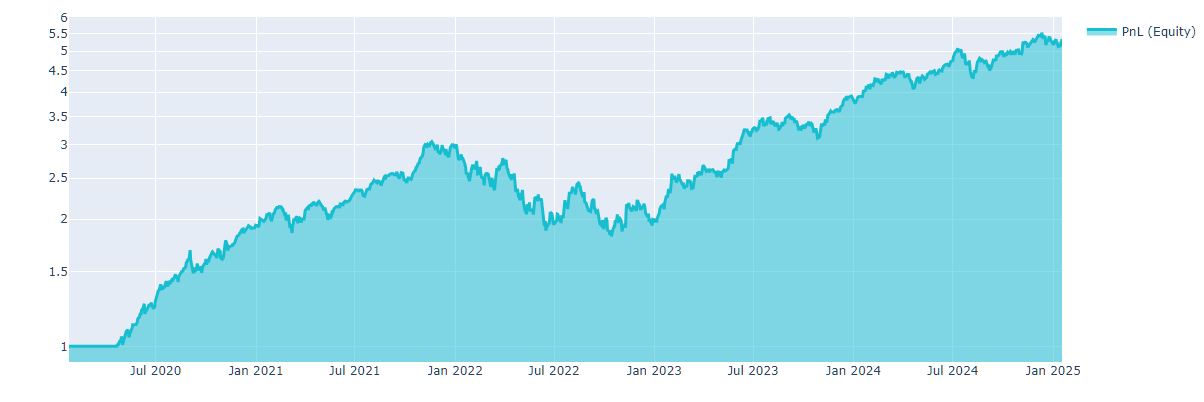
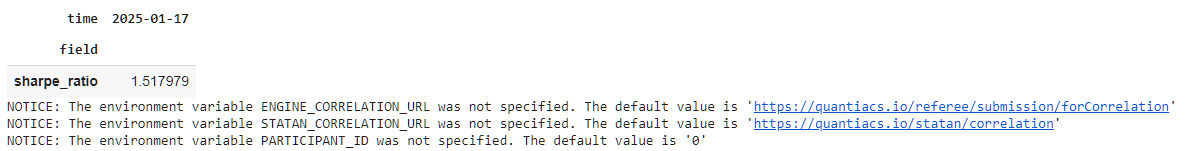
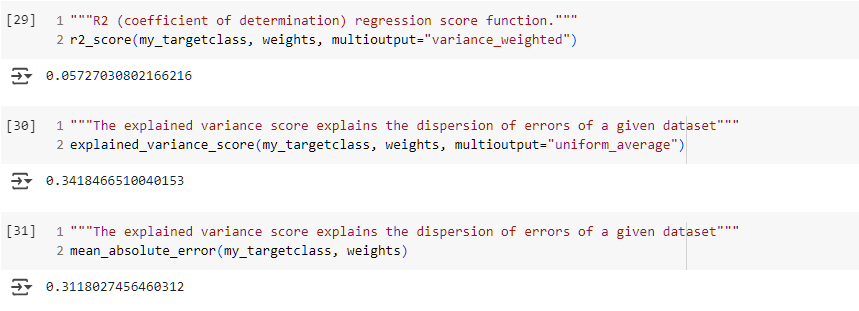
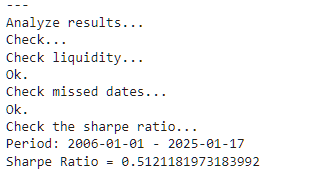